Aim to develop a model that predicts whether a biopsied breast cell is benign or malignant from 9 cell attributes.
(1) This is a classification problem with no interest in feature selection;
(2) Compare performance matrix of 10 classifers all at once;
(3) In case of mis-classification, false positive (type I error) is more acceptible than false negative (type II error) as the latter leads to more severe consequences in patients;

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from scipy import stats
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer as Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from string import ascii_letters
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

home = os.getcwd()
dir = os.path.join(os.path.dirname(home),r'data_challenge_1') #"data_challenge_1" folder

In [2]:
###
### Part(1a): inspect data types
###
data = pd.read_csv(os.path.join(dir, r'breast-cancer-wisconsin.csv'), index_col = 0, header = None,
                  names = ['Thickness', 'UniCellSize','UniCellShape','MargCellAdhesion','EpithCellSize',
                           'BareNuclei','BlandChromatin','NormalNucleoli','Mitoses','Class'])
print("Data has " + str(data.shape[0]) + ' observations with ' + str(data.shape[1]) + ' columns.')
print(data.dtypes) # inspect data type
#export_csv = data.to_csv (os.path.join(home,r'breast-cancer-wisconsin-jx.csv'),index = True,header = True)

Data has 699 observations with 10 columns.
Thickness            int64
UniCellSize          int64
UniCellShape         int64
MargCellAdhesion     int64
EpithCellSize        int64
BareNuclei          object
BlandChromatin       int64
NormalNucleoli       int64
Mitoses              int64
Class                int64
dtype: object


In [3]:
# Figure out what's going on with column "BareNuclei"
print("BareNuclei has the following values: " + str(data.BareNuclei.unique()))

# Coerce object columns to nullable integers
data['BareNuclei'] = pd.Series(pd.to_numeric(data['BareNuclei'], downcast = 'integer', errors = 'coerce'), 
                               dtype="Int64")
print("After cleaning, BareNuclei has the following values: " + str(data.BareNuclei.unique()))

#Impute missing values using multivariate feature imputation
imp = IterativeImputer(missing_values=np.nan, max_iter=10, random_state=0)
x = imp.fit_transform(data.drop('Class', axis = 1))
X = pd.DataFrame(x)

BareNuclei has the following values: ['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']
After cleaning, BareNuclei has the following values: <IntegerArray>
[1, 10, 2, 4, 3, 9, 7, NaN, 5, 8, 6]
Length: 11, dtype: Int64


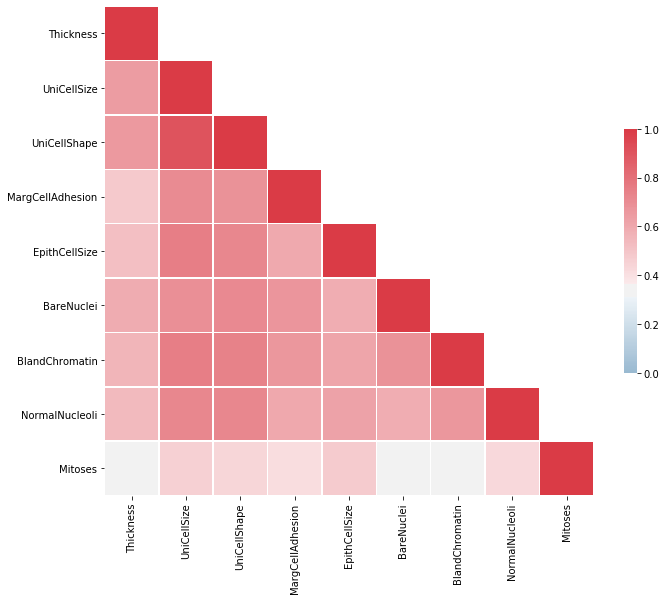

In [4]:
###
### Part(1b): inspect correlation between features
### 
corr = data.drop('Class', axis = 1).corr() # pearson correlation coefficient

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #return an array with the same type filled with False
mask[np.tril_indices_from(mask)] = True #set lower triangle to True
mask = np.invert(mask) #invert the array

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, mask = mask, vmax=1.0, vmin=0, center=np.amin(np.array(corr)),
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

All features are correlated with each other with coefficient between 0.3-0.9.
This indiates violation of assumptions if Naive Bayes were to be used.
Though if correlated features are all good predictors and we don't care about feature importance, 
such violation does no harm.

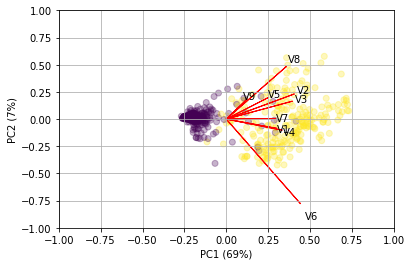

In [5]:
# explore the influence among features.
# credit to : https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot

#imp = Imputer(missing_values=np.nan, strategy='median') # impute missing values with feature median
#x = imp.fit_transform(data.drop('Class', axis = 1))

pca = PCA()
x_new = pca.fit_transform(x)
def myplot(score,coeff,color,labels=None, percent_exp=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = color, alpha = 0.3)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 1, shape = 'full')
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "V"+str(i+1), color = 'k', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'k', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{} ".format(1) + "(" + '{:.0f}'.format(percent_exp[0]*100) + "%)")
    plt.ylabel("PC{} ".format(2) + "(" + '{:.0f}'.format(percent_exp[1]*100) + "%)")
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],
       np.transpose(pca.components_[0:2, :]), 
       color = data['Class'],
       percent_exp = pca.explained_variance_ratio_[:2])
plt.show()

First component explains 69% of the variation and all features have positive loading scores. 
This suggests all features influences PC1 in the same direction.

In [6]:
###
### Part(2a): split training and testing data in 8:2 
###

# credit to: https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn
# credit to: https://www.kaggle.com/jeffd23/10-classifier-showdown-in-scikit-learn
y = ['B' if i==2 else 'M' for i in data['Class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
print(str(len(y_train)) + " training samples and " + str(len(y_test)) + " test samples.")

559 training samples and 140 test samples.


In [7]:
###
### Part(2b): compare 10 classifiers 
###

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025,probability=True),
    SVC(gamma=2, C=1,probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


log_cols=["Classifier", "Accuracy", "Log Loss", "FN"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    index = classifiers.index(clf)
    #name = clf.__class__.__name__
    name = names [index]
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = metrics.accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    confusion_matrix = metrics.confusion_matrix(y_test, train_predictions)
    FN = confusion_matrix[1][0]
    print("False Negative: {}".format(FN))
    
    train_predictions = clf.predict_proba(X_test)
    ll = metrics.log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    #train_pred_label = pd.DataFrame(train_predictions)
    #judge=train_pred_label.iloc[:,0]>train_pred_label.iloc[:,1]
    #pred=["B" if i==True else "M" for i in judge]

    log_entry = pd.DataFrame([[name, acc*100, ll, FN]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

Nearest Neighbors
****Results****
Accuracy: 95.0000%
False Negative: 3
Log Loss: 0.31695836422703416
Linear SVM
****Results****
Accuracy: 95.7143%
False Negative: 2
Log Loss: 0.0950696950593517
RBF SVM
****Results****
Accuracy: 81.4286%
False Negative: 0
Log Loss: 0.3010194477487813
Gaussian Process
****Results****
Accuracy: 97.1429%
False Negative: 2
Log Loss: 0.09201191226903294
Decision Tree
****Results****
Accuracy: 92.8571%
False Negative: 6
Log Loss: 1.3237155750385685
Random Forest
****Results****
Accuracy: 95.7143%
False Negative: 2
Log Loss: 0.10716112283264967
Neural Net
****Results****
Accuracy: 97.1429%
False Negative: 2
Log Loss: 0.07823409757520318
AdaBoost
****Results****
Accuracy: 94.2857%
False Negative: 4
Log Loss: 0.5275224507075134
Naive Bayes
****Results****
Accuracy: 95.0000%
False Negative: 3
Log Loss: 0.6422338225479672
QDA
****Results****
Accuracy: 95.0000%
False Negative: 2
Log Loss: 0.608304502929673


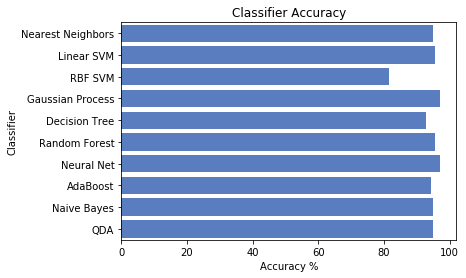

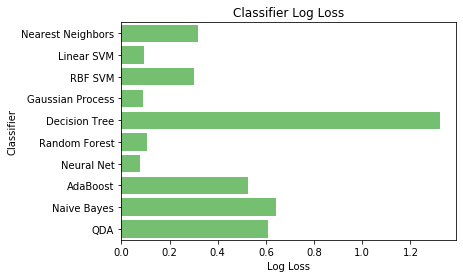

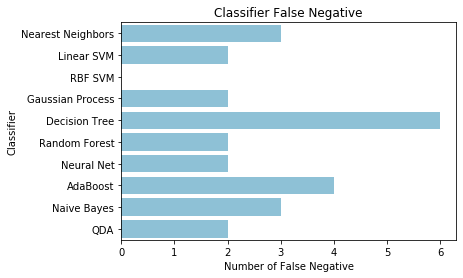

In [8]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='FN', y='Classifier', data=log, color="c")

plt.xlabel('Number of False Negative')
plt.title('Classifier False Negative')
plt.show()

In [9]:
log

,Classifier,Accuracy,Log Loss,FN
0,Nearest Neighbors,95.000000,0.316958,3
0,Linear SVM,95.714286,0.095070,2
0,RBF SVM,81.428571,0.301019,0
0,Gaussian Process,97.142857,0.092012,2
0,Decision Tree,92.857143,1.323716,6
0,Random Forest,95.714286,0.107161,2
0,Neural Net,97.142857,0.078234,2
0,AdaBoost,94.285714,0.527522,4
0,Naive Bayes,95.000000,0.642234,3
0,QDA,95.000000,0.608305,2


In [11]:
#Gaussian process performs best after leveraging accuracy, log loss and false negative.
#Neural net performs equally well with GP but is more computationally expensive.
favorite_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
favorite_clf.fit(X_train, y_train)

predictions = favorite_clf.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

array([[94,  2],
       [ 2, 42]])

In [12]:
# Save model
from joblib import dump, load
dump(favorite_clf, 'clf_GP.joblib') 

['clf_GP.joblib']